# 8. Neural network 2

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation

## 8.1 Automatic diffetentiation

### 8.1.4 Implementation of automatic differentiation

In [2]:
x = torch.tensor([1, -1], dtype=torch.float)
w = torch.tensor([1, 0.5], dtype=torch.float, requires_grad=True)

loss = -torch.dot(x, w).sigmoid().log()
loss.backward()
print(loss.item())
print(w.grad)

0.4740769565105438
tensor([-0.3775,  0.3775])


## 8.2 Training single layer neural network

In [3]:
def init_graph(X, dpi=100, figsize=(6,6)):
    xmin, xmax = X[:,0].min()-0.5, X[:,0].max()+0.5
    ymin, ymax = X[:,1].min()-0.5, X[:,1].max()+0.5

    fig, ax = plt.subplots(dpi=dpi, figsize=figsize)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    return fig, ax

def plot_data(ax, X, Y):
    I = np.where(Y == 0)
    ax.scatter(X[I,0], X[I,1], c='tab:blue', marker='_')
    I = np.where(Y == 1)
    ax.scatter(X[I,0], X[I,1], c='tab:red', marker='+')
    
def draw_heatmap(fig, ax, func, step=1, N=1024):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    XX, YY = np.meshgrid(np.linspace(xmin, xmax, N), np.linspace(ymin, ymax, N))
    XY = np.vstack([XX.ravel(), YY.ravel()]).T

    X_ = torch.from_numpy(XY).type(dtype)
    Y_ = func(X_).detach().numpy().copy()
    C = Y_.reshape(XX.shape)

    vmin, vmax = C.min(), C.max()
    vmin = ((vmin // step) - 1) * step
    vmax = ((vmax // step) + 1) * step
    width = max(abs(vmin), abs(vmax))
    
    mesh = ax.pcolormesh(XX, YY, C, norm=matplotlib.colors.Normalize(vmin=-width, vmax=width), cmap='bwr', shading='auto', alpha=0.2)
    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label('Output value')
    
    cont = ax.contour(XX, YY, C, colors='tab:gray', linewidths=0.5, linestyles='dashed', levels=np.arange(vmin, vmax+1, step))
    cont.clabel(fmt='%1.1f')

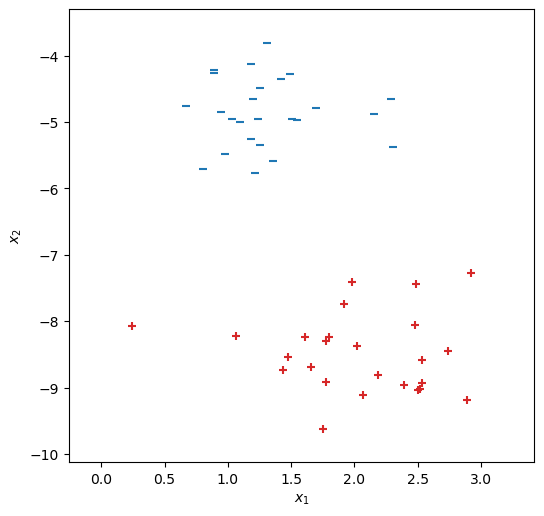

In [4]:
from sklearn.datasets import make_blobs
D = make_blobs(n_samples=50, centers=2, random_state=129, cluster_std=.6)

fig, ax = init_graph(D[0])
plot_data(ax, D[0], D[1])
plt.show()

In [7]:
# Convert numpy object to pytorch object
from torch.utils.data import TensorDataset, DataLoader

dtype=torch.float 
X = torch.from_numpy(D[0]).type(dtype)
Y = torch.from_numpy(D[1].reshape(-1, 1)).type(dtype)

In [8]:
X[:4]

tensor([[ 2.4885, -7.4323],
        [ 1.4338, -8.7279],
        [ 2.1874, -8.8029],
        [ 1.1995, -4.6490]])

In [9]:
Y[:4]

tensor([[1.],
        [1.],
        [1.],
        [0.]])

### 8.2.1 Naive implementation

In [10]:
# Data loader with batch size of 4
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Parameters
w = torch.randn(2, 1, dtype=dtype, requires_grad=True)
b = torch.randn(1, dtype=dtype, requires_grad=True)

# SGD
H = [] # history of loss
lr = 0.01
for t in range(1000):
    sumloss = 0.
    for x, y in loader:
        y_hat = (x.matmul(w) + b).sigmoid()
        l = y * y_hat + (1 - y) * (1 - y_hat)
        loss = -l.log().sum()
        sumloss += loss.item()

        loss.backward()
        with torch.no_grad(): # Disable gradient calculation in this block
            w -= lr * w.grad
            b -= lr * b.grad
            w.grad.zero_() # reset gradient
            b.grad.zero_() # reset gradient
    
    H.append(sumloss)

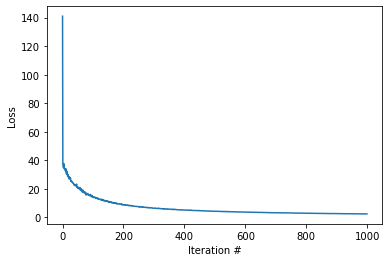

In [11]:
fig, ax = plt.subplots()
ax.plot(H)
ax.set_xlabel('Iteration #')
ax.set_ylabel('Loss')
plt.show()

In [12]:
w, b

(tensor([[ 0.2994],
         [-1.9087]], requires_grad=True),
 tensor([-12.9739], requires_grad=True))

<ipython-input-3-bcc4aa8c7e97>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  ax.scatter(X[I,0], X[I,1], c='tab:blue', marker='_')


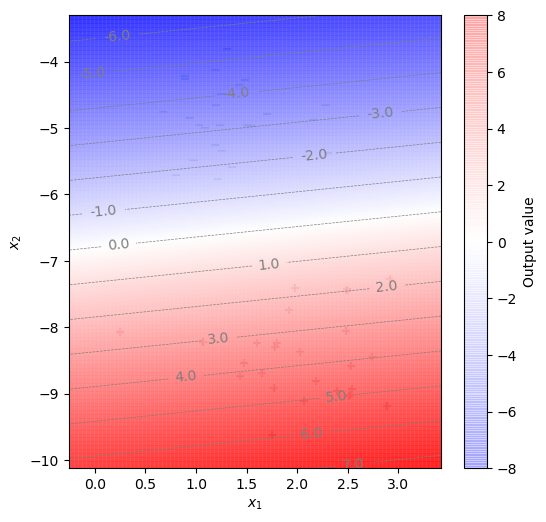

In [13]:
def model(x):
    return x.matmul(w) + b

fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()

### 8.2.2 Implementation with Sequential

In [14]:
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Single layer NN 
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1, bias=True)
)
loss_fn = torch.nn.BCEWithLogitsLoss()

# SGD
lr = 0.1
for t in range(1000):
    for x, y in loader:
        y_hat = model(x)
        loss = loss_fn(y_hat, y)

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            for param in model.parameters():
                param -= lr * param.grad

In [15]:
model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)

In [16]:
model.state_dict()

OrderedDict([('0.weight', tensor([[ 0.5600, -2.5326]])),
             ('0.bias', tensor([-17.4576]))])

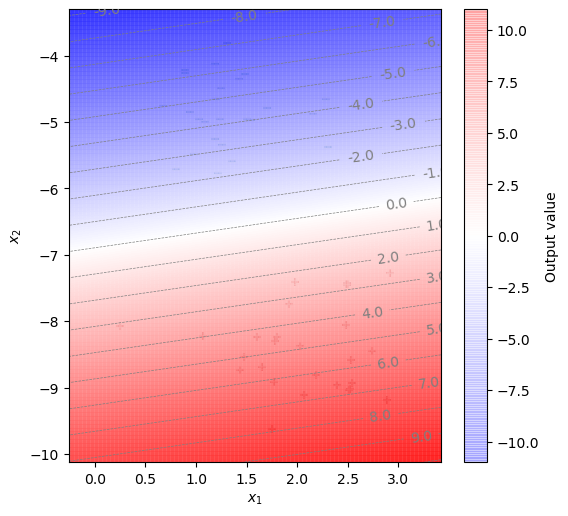

In [17]:
fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()

### 8.2.3 Implementation with Sequential and SGD

In [18]:
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Single layer NN 
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1, bias=True)
)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

for t in range(1000):
    for x, y in loader:
        y_hat = model(x)
        loss = loss_fn(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

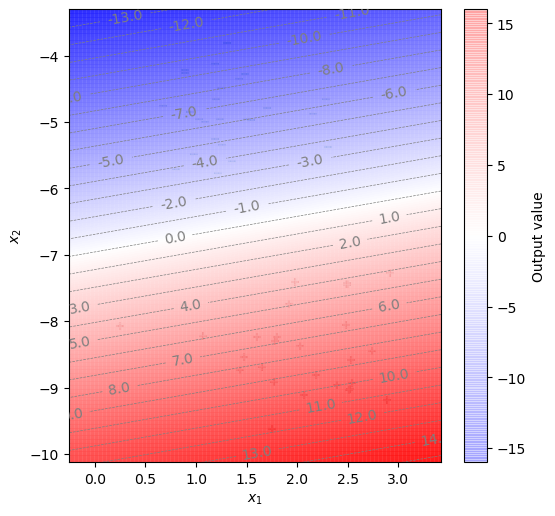

In [19]:
fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()

### 8.2.4 Define NN class

In [20]:
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Define a neural network as a class
class SingleLayerNN(torch.nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.linear1 = torch.nn.Linear(d_in, d_out, bias=True)

    def forward(self, x):
        return self.linear1(x) 

model = SingleLayerNN(2, 1)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

for t in range(1000):
    for x, y in loader:
        y_hat = model(x)
        loss = loss_fn(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

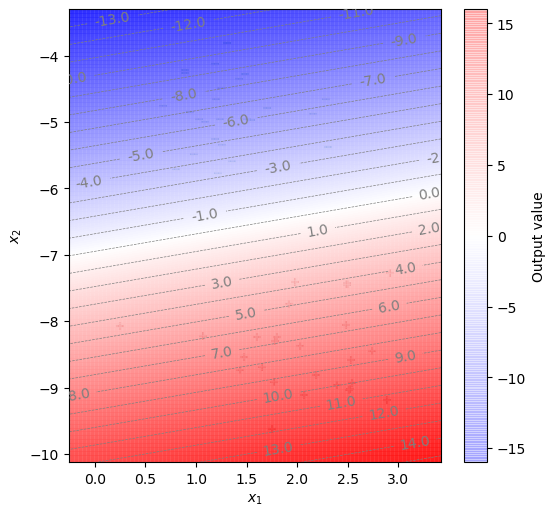

In [21]:
fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()

In [22]:
model.state_dict()

OrderedDict([('linear1.weight', tensor([[ 0.9903, -3.7716]])),
             ('linear1.bias', tensor([-26.2018]))])

## 8.3 Multi layer neural network